# Could sticking to the Paris Agreement limit of 1.5$^{\circ}$C avoid mass mortality on the Great Barrier Reef?


#### notes: 
    
the mini-pracs should take no more than 25 minutes, ideally with a mixture of into lecture (~10 mins) and then the remainder of the time for students to do something interactive. The goal here is to highlight some really cool Exeter research you're doing, ideally with some links to potential dissertation research projects and/or 3rd year modules -- at the end of the practical students would ideally be excited about opportunities to learn/research at Exeter.

## Introduction

Example task:

Projections for GBRMPA

Note to Paul. script in /Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran

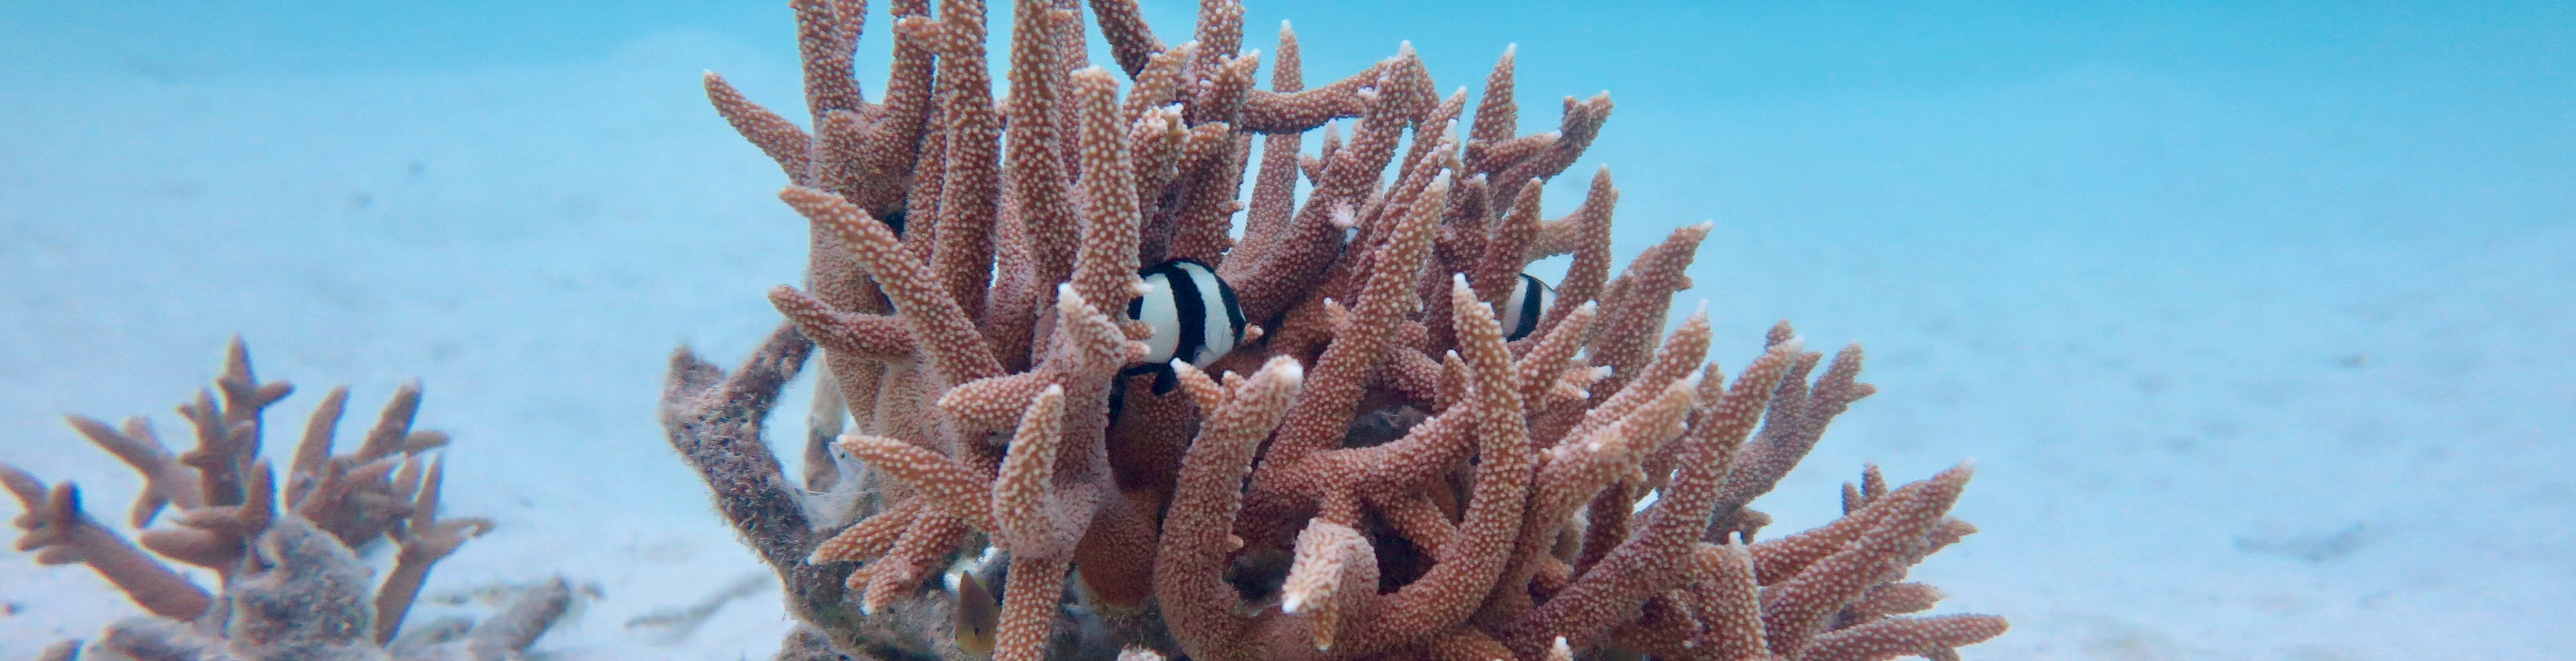

In [138]:
from IPython.display import Image
Image(filename='images/IMG_4919.jpeg') 

HOW MUCH CORAL BLEACHING MIGHT BE AVOIDED BY HITTING THE PARIS AGREEMENT TARGETS?

## Setup
This section imports some bits of code we will use later. If you're interested in what is going on behind the scenes, let me know.

In [139]:
import iris
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy
import plot_north_south_depth_section
import plot_east_west_depth_section
import plot_different_vertical_levels
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=UserWarning)
import iris.coord_categorisation
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import t
import pickle
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


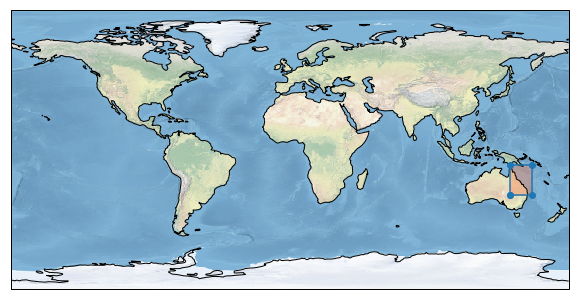

In [140]:

x, y = [142.0,156.0,156.0,142.0,142.0], [-29.0,-29.0,-10.0,-10.0,-29.0]

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.plot(x, y, marker='o', transform=ccrs.PlateCarree())
ax.fill(x, y, transform=ccrs.PlateCarree(), color='coral', alpha=0.4)

plt.show()

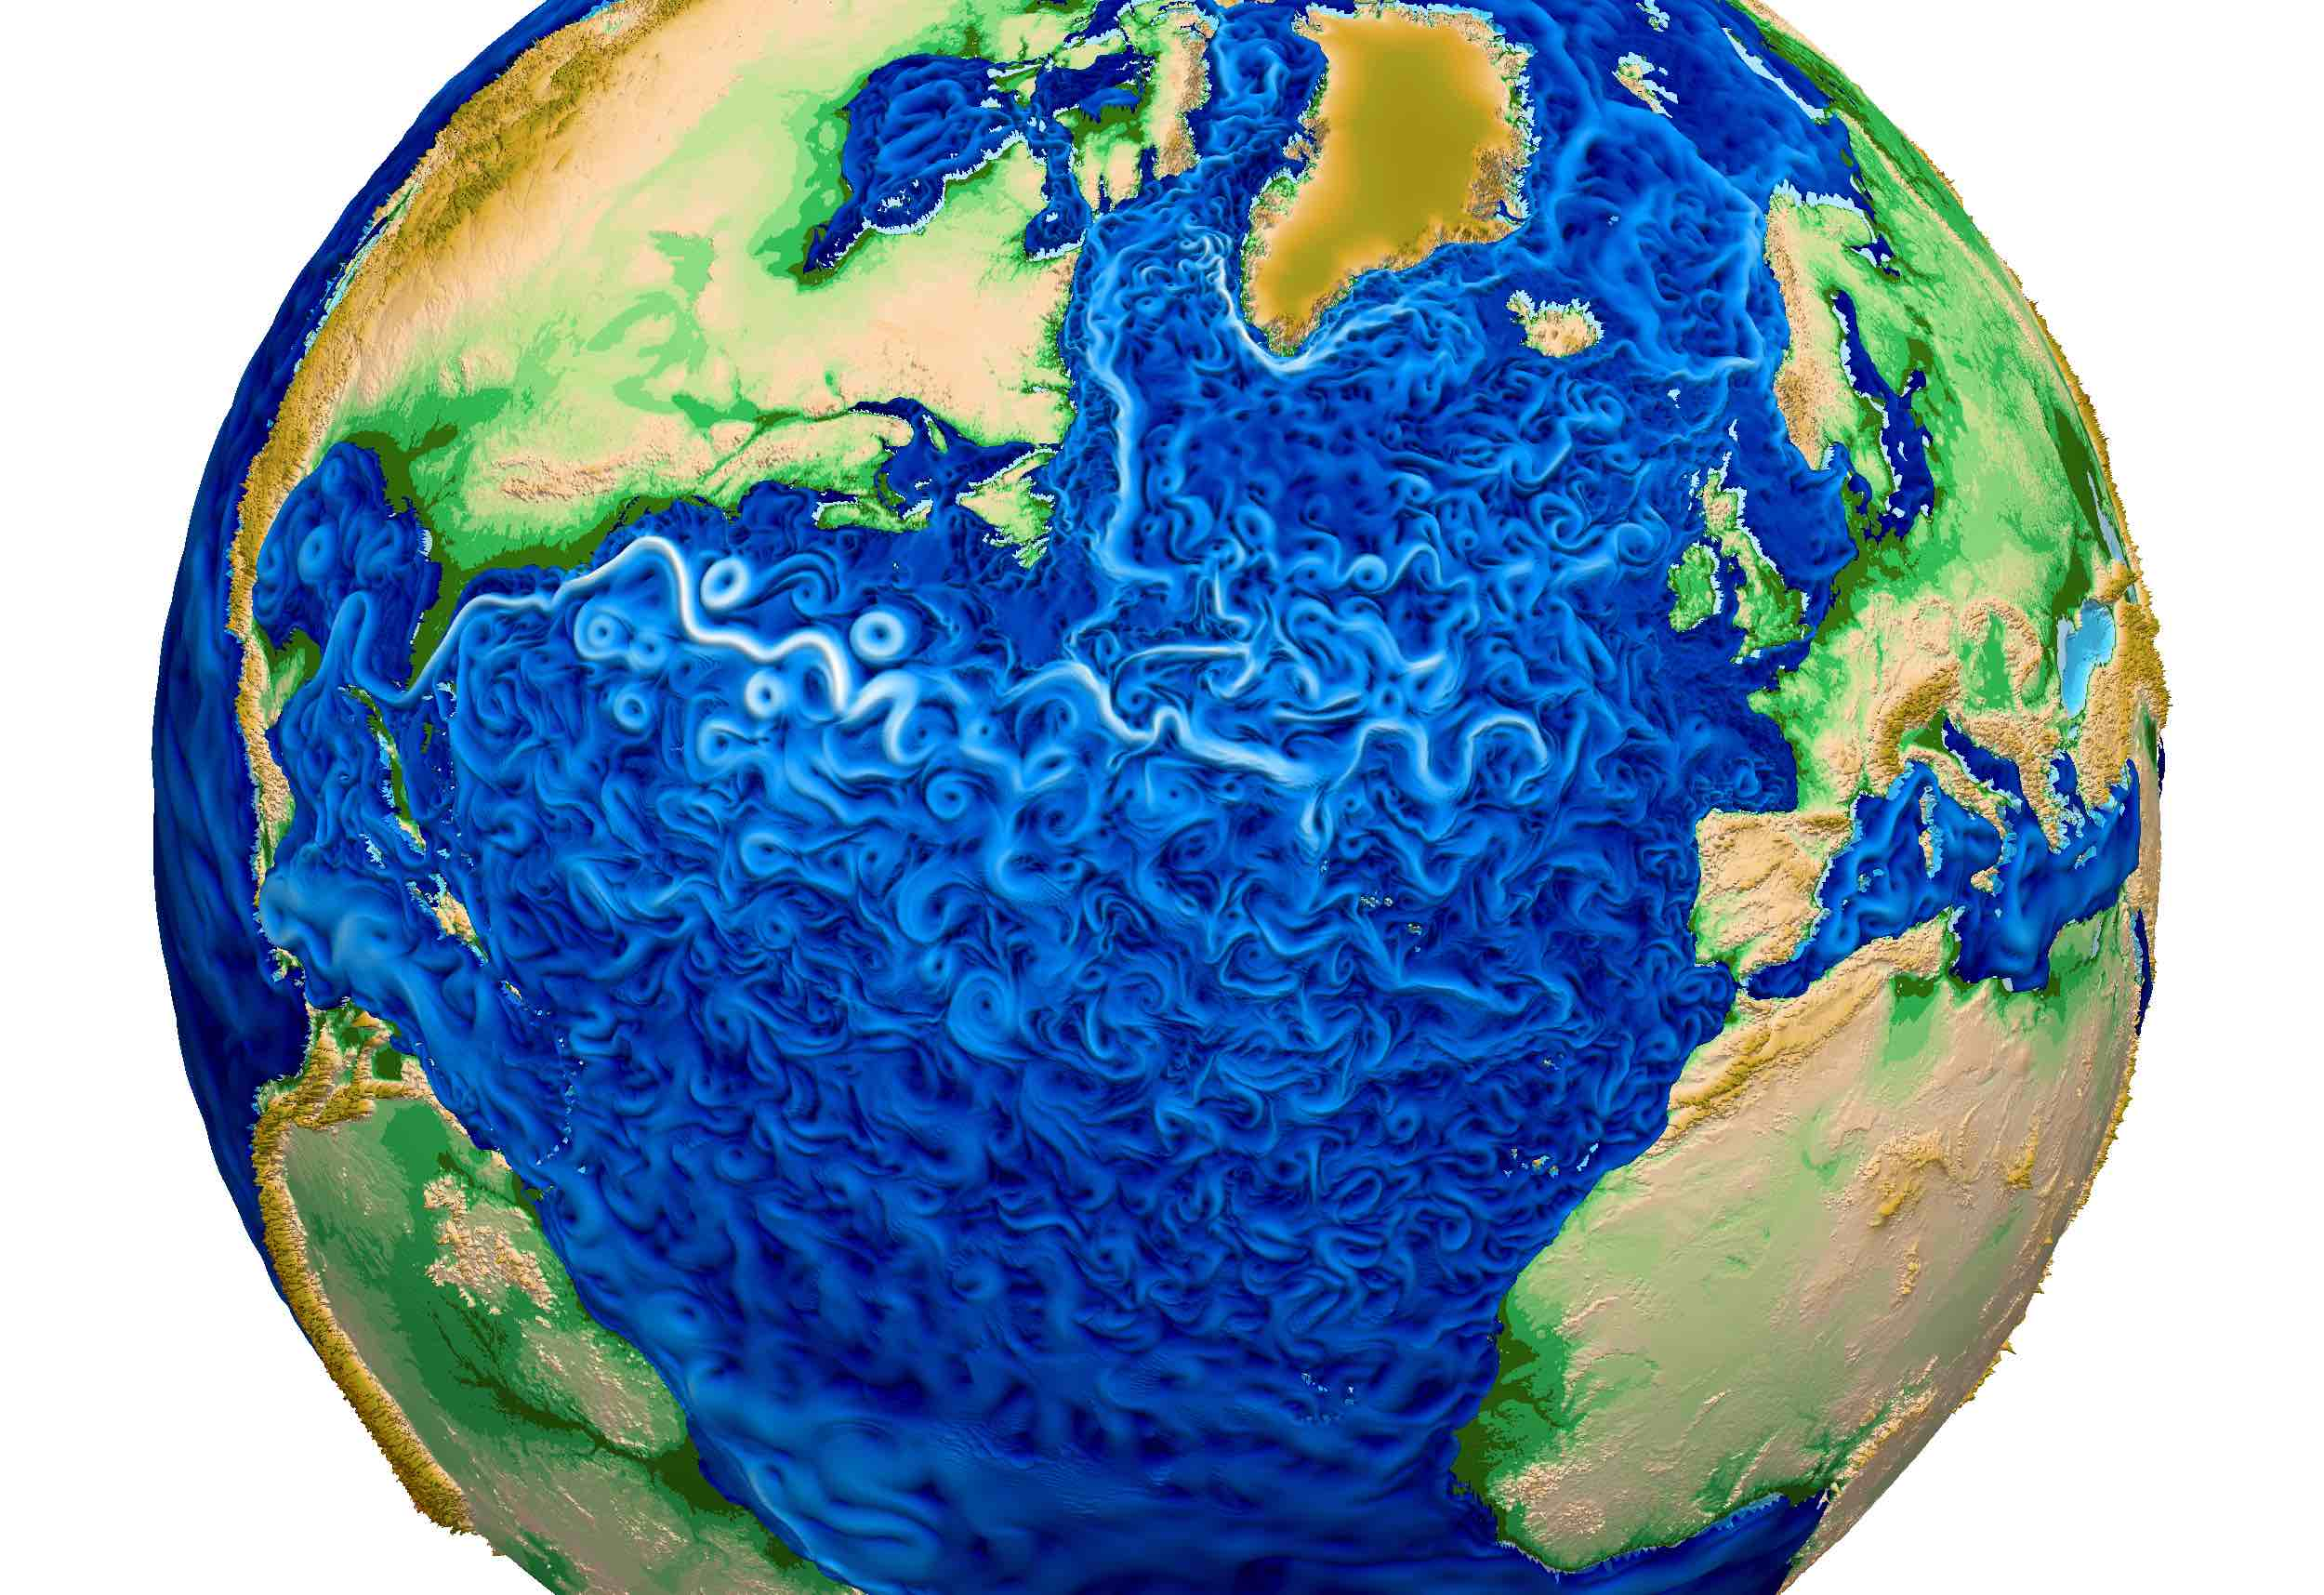

In [141]:
Image(filename='images/ke_log_warped_NA_white_small.jpg') 

In [142]:
def mmm_skirving(cube):
    cube = cube.aggregated_by(['year','month_number'], iris.analysis.MEAN)
    print 'calculating NOAA Skirving MMM for month:'
#     missing_data_value_greater_than = -32768.0
#     missing_data_equals = -32768.0
    missing_data_equals = cube.data.fill_value
    print 'NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        print i+1
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:][0]
        tmp[np.where(tmp == missing_data_equals )] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology


def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology
    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube


def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
#     return n,slope,intercept,p_val,r_square,rmse
    return slope,intercept


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)

def asb(cube,threshold):
    dhvalue_cube_gbr_tmp = cube.copy()
    dhvalue_cube_gbr_tmp_data = dhvalue_cube_gbr_tmp.data
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data <= threshold)] = 0.0
    dhvalue_cube_gbr_tmp_data[np.where(dhvalue_cube_gbr_tmp_data > threshold)] = 1.0
    dhvalue_cube_gbr_tmp.data = dhvalue_cube_gbr_tmp_data
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.copy()
    dhvalue_cube_gbr_asb = dhvalue_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhvalue_cube_gbr_asb_tmp = dhvalue_cube_gbr_asb.data
    dhvalue_cube_gbr_asb_tmp[np.where(dhvalue_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhvalue_cube_gbr_asb.data = dhvalue_cube_gbr_asb_tmp
    return dhvalue_cube_gbr_asb

def year_of_1st_occurance(asb_cube):
    yrs = asb_cube.coord('year').points
    tmp_cube = asb_cube.copy()
    data = tmp_cube.data.copy()
    for i,yr in enumerate(yrs):
        data[i][np.where(data[i] == 1)] = yr
    data[np.where(data == 0)] = np.nan
    year_of_1st_occurance_cube = asb_cube[0].copy()
    year_of_1st_occurance_cube.data = np.nanmin(data,axis=0)
    return year_of_1st_occurance_cube



In [143]:
directory = '/Users/ph290/Downloads/s2p3_cmip6/'

models = ['CanESM5','MRI-ESM2-0','EC-Earth3-Veg','ACCESS-CM2','CNRM-ESM2-1','MPI-ESM1-2-HR','UKESM1-0-LL']
experiments = ['585','119']
variables = ['surfacetemperature']

model = models[0]
experiment = experiments[0]
variable = variables[0]

# cube_119 = iris.load_cube('/Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran/data/EC-Earth3-Veg_global_hist_119_GBR_bottomtemperature.nc')
cube_119 = iris.load_cube('/Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran/data/UKESM1-0-LL_global_hist_119_GBR_surfacetemperature.nc')

cube_119.data = np.ma.masked_array(cube_119.data)
cube_119.data.fill_value = 9.96921e+36
iris.coord_categorisation.add_year(cube_119, 'time', name='year')
iris.coord_categorisation.add_month(cube_119, 'time', name='month')
iris.coord_categorisation.add_month_number(cube_119, 'time', name='month_number')

# cube_585 = iris.load_cube('/Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran/data/EC-Earth3-Veg_global_hist_585_GBR_bottomtemperature.nc')
cube_585 = iris.load_cube('/Users/ph290/Documents/HalloranSync/documents/jupyter_github/Jupiter_notebooks_halloran/data/UKESM1-0-LL_global_hist_585_GBR_surfacetemperature.nc')

cube_585.data = np.ma.masked_array(cube_585.data)
cube_585.data.fill_value = 9.96921e+36
iris.coord_categorisation.add_year(cube_585, 'time', name='year')
iris.coord_categorisation.add_month(cube_585, 'time', name='month')
iris.coord_categorisation.add_month_number(cube_585, 'time', name='month_number')




In [144]:
mmm_climatology_119 = mmm_skirving(cube_119)
mmm_climatology_585 = mmm_skirving(cube_585)



calculating NOAA Skirving MMM for month:
NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)
(336, 190, 140)
1
2


/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in divide
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in divide


3
4
5
6
7
8
9
10
11
12
calculating NOAA Skirving MMM for month:
NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)
(336, 190, 140)
1
2
3
4
5
6
7
8
9
10
11
12


In [145]:
dhw_cube_119 = dhw(cube_119,mmm_climatology_119,[2010,2100])
dhw_cube_585 = dhw(cube_585,mmm_climatology_585,[2010,2100])

In [ ]:
asb_cube_119 = asb(dhw_cube_119,8.0)
asb_cube_585 = asb(dhw_cube_585,8.0)

In [ ]:
year_of_1st_occurance_cube_119 = year_of_1st_occurance(asb_cube_119)
year_of_1st_occurance_cube_585 = year_of_1st_occurance(asb_cube_585)




In [ ]:
fig,axes= plt.subplots(nrows=1, ncols=2,figsize=(5, 10))
plt.subplot(121)
qplt.pcolormesh(year_of_1st_occurance_cube_585)
plt.gca().coastlines()
plt.subplot(122)
qplt.pcolormesh(year_of_1st_occurance_cube_585)
plt.gca().coastlines()

plt.colorbar()

In [ ]:
iris.save(mmm_climatology_119, 'data/mmm_climatology_119.nc')
iris.save(asb_cube_119, 'data/asb_cube_119.nc')
iris.save(year_of_1st_occurance_cube_119, 'data/year_of_1st_occurance_cube_119.nc')

iris.save(mmm_climatology_585, 'data/mmm_climatology_585.nc')
iris.save(asb_cube_585, 'data/asb_cube_585.nc')
iris.save(year_of_1st_occurance_cube_585, 'data/year_of_1st_occurance_cube_585.nc')

iris.save(dhw_cube_119, 'data/dhw_cube_119.nc')
iris.save(dhw_cube_585, 'data/dhw_cube_585.nc')



In [ ]:
cube_119_ann_avg = cube_119.aggregated_by(['year'], iris.analysis.MEAN)
cube_119_ann_max = cube_119.aggregated_by(['year'], iris.analysis.MAX)
cube_585_ann_avg = cube_585.aggregated_by(['year'], iris.analysis.MEAN)
cube_585_ann_max = cube_585.aggregated_by(['year'], iris.analysis.MAX)

In [ ]:

qplt.plot(area_avg(cube_119))

In [ ]:
x.data


In [ ]:
qplt.plot(cube_119_ann_avg,'k')
qplt.plot(cube_585_ann_avg,'k')
qplt.plot(cube_119_ann_max,'r')
qplt.plot(cube_585_ann_max,'r')

Here we are reading in the dataset we want to interrogate

In [ ]:
cube = iris.load_cube('data/gbrish_era5_surfacetemperature.nc') # this 
cube.data = np.ma.masked_where(cube.data > 1.0e35,cube.data)

cube_bottom = iris.load_cube('data/gbrish_era5_bottomtemperature.nc') # this 
cube_bottom.data = np.ma.masked_where(cube_bottom.data > 1.0e35,cube_bottom.data)

## Analysing the data

The three plots below allow you to explore the dataset. 
Edit the numbers in green, and re-run the script (>>) and explore what the plots are telling you


-----------------------------------

### Plot data at a certain depth level

In [ ]:
depth = 200 # depth in meters

The code below produces the plot. Note, white areas are where there is no data - typically land.

In [ ]:
plt.figure(figsize=(12, 5))

day=0

plt.subplot(131)
iplt.pcolormesh(cube[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

plt.subplot(132)
iplt.pcolormesh(cube_bottom[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

plt.subplot(133)
iplt.pcolormesh(cube[day] - cube_bottom[day])
plt.gca().coastlines('50m')
plt.colorbar(orientation='vertical')

-----------------------------------

### Latitude v. depth plots
Specify the latitude and longitude values that describe the region you want to explore, then run the script (>>) and examine the plot.

In [ ]:
westernmost_longitude = -60.0 # this should be a value between -180 and 180 degrees
easternmost_longitude = -50.0 # this should be a value between -180 and 180 degrees
southernmost_latitude = -90 # this should be a value between -90 and 90 degrees
northernmost_latitude = 90 # this should be a value between -90 and 90 degrees

The code below produces the plot. Note, white areas are where there is no data - typically land.

In [ ]:
plot_north_south_depth_section.plot(westernmost_longitude,easternmost_longitude,southernmost_latitude,northernmost_latitude,cube)

Play with the latitude and longitude values in the box below, then run the script to plot up East-West sections down through the ocean for those regions

-----------------------------------

### Longitude v. depth plots
Specify the latitude and longitude values that describe the region you want to explore, then run the script (>>) and examine the plot.

In [ ]:
westernmost_longitude = -180 # this should be a value between -180 and 180 degrees
easternmost_longitude = 180 # this should be a value between -180 and 180 degrees
southernmost_latitude = -5 # this should be a value between -90 and 90 degrees
northernmost_latitude = 5 # this should be a value between -90 and 90 degrees

The code below produces the plot. Note, white areas are where there is no data - typically land.

In [ ]:
plot_east_west_depth_section.plot(westernmost_longitude,easternmost_longitude,southernmost_latitude,northernmost_latitude,cube)